In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [14]:
#three metrics: 
#1) fraction correct (Can't do it now, the data only has correct trials)
#2) time2target ()
#3) straightness

#For this plot, show data for each trial, without separating by target
save_dir = os.path.join(r'D:\Dropbox\BMI_co_obs_paper\data\vivek', 'b_basic_stat')
os.path.exists(save_dir)

True

In [47]:
#loop task
#loop target
#extract trials

#Initialize: 
d_list = ['time', 'orthog_area_norm', 'target']
r = {}
for d in d_list: 
    for task in range(num_tasks):
        r[(task,d)] = []

#Trial boundaries:
trial_start = np.where((df['trial_start']==1))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

#trial_len, straightness:
for bnd in trial_bound: 
    x = df['kin_px'][bnd[0]:bnd[1]+1]
    y = df['kin_py'][bnd[0]:bnd[1]+1]
    
    task = int(df['task'][bnd[0]])
    t = int(df['target'][bnd[0]])
    t_pos = target_pos[t,:]
    sa, a, df_a = bmi_b.traj_signed_area_about_target_axis(x, y, t_pos)
    trl_len = bnd[1]+1-bnd[0]
    orthog_area_norm = a/trl_len #normalize the area about target axis by number of samples in trajectory
    
    
    #ASSIGN:
    r[(task,'target')].append(t)
    r[(task,'time')].append(trl_len*0.1)
    r[(task,'orthog_area_norm')].append(orthog_area_norm)    

#Convert to np array: 
for d in d_list: 
    for task in range(num_tasks):
        r[(task,d)] = np.array(r[(task,d)])
        r[(task,d,'mean')] = r[(task,d)].mean()
        r[(task,d,'sem')] = sio_stat.sem(r[(task,d)], axis=0, nan_policy='omit')  
        

In [28]:
target_color

['maroon',
 'orangered',
 'darkgoldenrod',
 'olivedrab',
 'teal',
 'steelblue',
 'midnightblue',
 'darkmagenta']

<IPython.core.display.Javascript object>


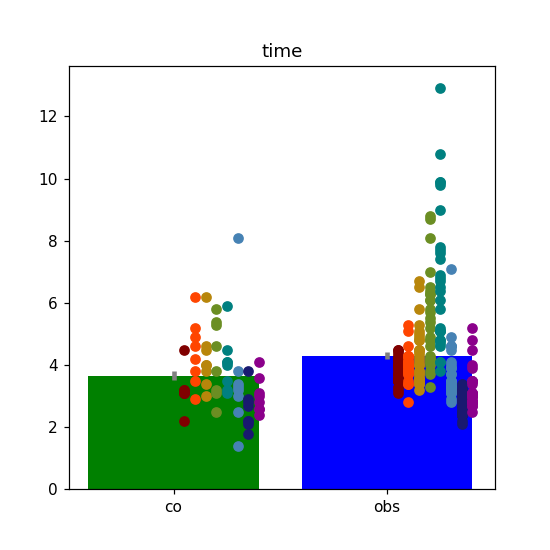

<IPython.core.display.Javascript object>


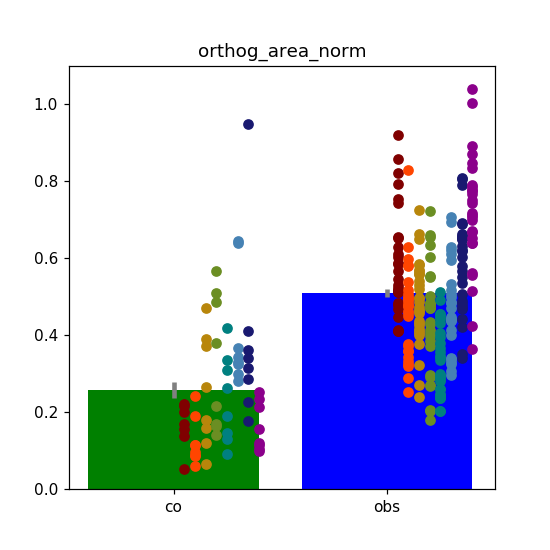

In [50]:
task_color = ['g', 'b']
d_plot = ['time', 'orthog_area_norm']
scatter_trials = True
save_bool = False
ext_list = ['.png', '.eps']

target_scatter_offset = [0.05, 1.05]
target_scatter_incr = [0.05, 0.05]

for d in d_plot:
    plt.figure(figsize=(5,5))
    for task in range(num_tasks):
        plt.bar(task, np.mean(r[task,d,'mean']), color=task_color[task])
        sem_min = r[task,d,'mean']-r[task,d,'sem']
        sem_max = r[task,d,'mean']+r[task,d,'sem']
        plt.vlines(task, sem_min, sem_max, color=np.ones(3)*0.5, linewidth=3)
        
        if scatter_trials:
            #scatter individual trials:
            for target in range(num_targets):
                y_data = r[task,d][r[task,'target']==target]
                x_data = np.ones(y_data.shape)*(target_scatter_offset[task]+target*target_scatter_incr[task])
                plt.scatter(x_data, y_data, color=target_color[target], zorder=1000)
            
    plt.title(d)
    plt.xticks((0,1), ('co', 'obs'))
    if save_bool:
        if scatter_trials:
            for ext in ext_list:
                save_name = d + '_trial_scatter' + ext
                plt.savefig(os.path.join(save_dir, save_name))

In [49]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\b_basic_stat'

In [12]:
print(r[0,'time','mean'])
print(r[1,'time','mean'])

3.661904761904762
4.306756756756758
